In [1]:
import sys
import os
import re
import psycopg2 # ignore the warning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
try:
    conn = psycopg2.connect("dbname='litindex' user='python' host='3.16.15.91' password='python'")
except:
    print("Connection failed")
    
cur = conn.cursor()

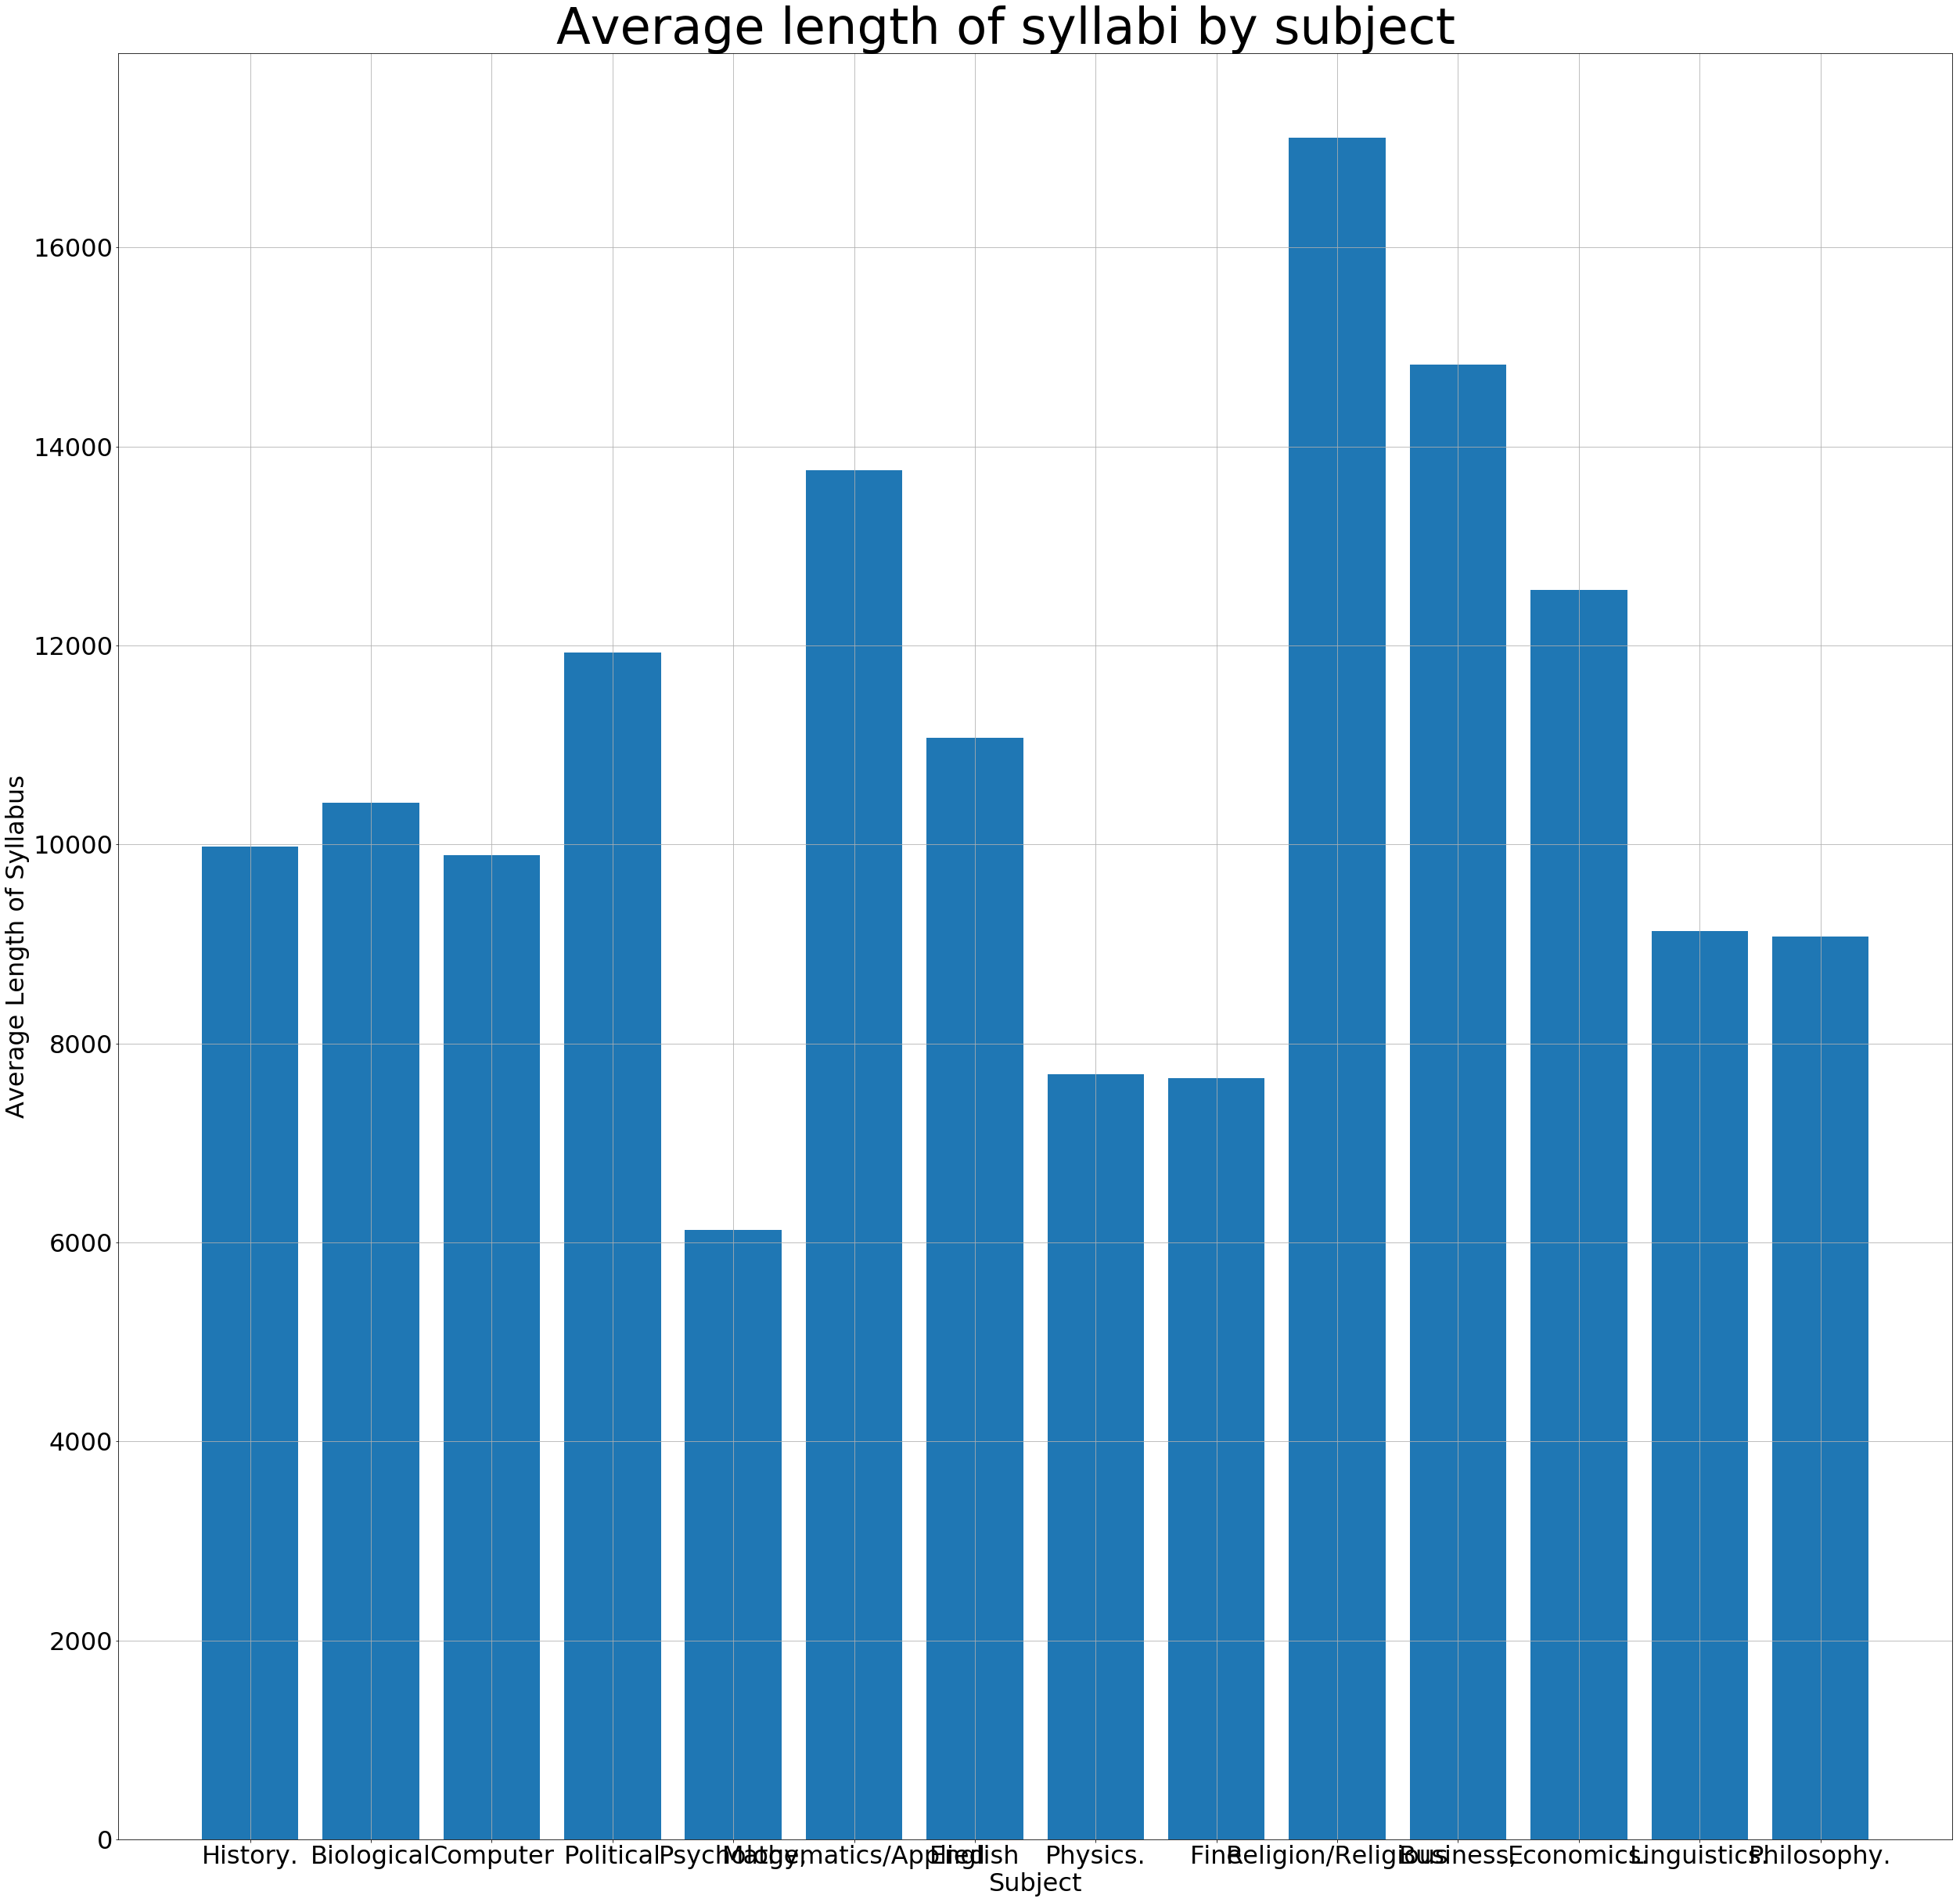

In [3]:
# an easy thing to analyze would be the average length of the syllabi per department
# let's call that metric ALS (no reference to the disease intended)
cur.execute("SELECT field_name, AVG(length(content)) AS avg_length FROM syllabus GROUP BY field_name")
subj = []
avg_len = []

for row in cur:
    subj.append(row[0].split(' ')[0]) # again, trim the subject
    avg_len.append(row[1])
    
_ = plt.figure(figsize=(42, 42))
_ = plt.bar(subj, avg_len)
_ = plt.xlabel('Subject', fontsize=32)
_ = plt.ylabel('Average Length of Syllabus', fontsize=32)
_ = plt.tick_params(axis='both', which='major', labelsize=32)
_ = plt.tick_params(axis='both', which='minor', labelsize=32)
_ = plt.suptitle("Average length of syllabi by subject", fontsize=64, y = .9)
_ = plt.grid()

In [4]:
# It's interesting to see how religious studies and business syllabi are so long, whereas psychology is so short
# But that aside, it's interesting to see that the similarity between this graph and the AOHPD graph from part 1 is not as strong as I predicted
# Longer syllabi don't necessarily indicate more "office hour" usage

# A good syllabus should clearly outline the course goals and offer transparent correspondance
# The length of a syllabus may indicate the degree to which a department is willing to do so
# Which could also indicate the amount and quality of education offered
# Although seemingly trivial, this may be important to factor into our index of liberal arts education offering

In [5]:
# Something interesting to understand would be the presence of prerequisites on the syllabus
# Let's start off by seeing how frequent prereqs are on the syllabus

cur.execute("SELECT A.field_name, num_prereqs, total_syllabi, CAST(num_prereqs AS decimal) / total_syllabi AS percentage FROM (SELECT field_name, COUNT(*) AS num_prereqs FROM syllabus WHERE content LIKE '%prereq%' OR content LIKE '%Prereq%' GROUP BY field_name) A INNER JOIN (SELECT field_name, COUNT(*) AS total_syllabi FROM syllabus GROUP BY field_name) B ON A.field_name = B.field_name")
syllabi_count = []
percentage_count = []
domains = []

for row in cur:
    print('{}: {}'.format(row[0], row[1]), row[2], row[3]) # I got tired of drawing bar graphs
    domains.append(row[0].split(' ')[0])
    syllabi_count.append(row[2])
    percentage_count.append(row[3])

Biological and Biomedical Sciences, General/Other.: 4 11 0.36363636363636363636
Computer and Information Sciences.: 13 35 0.37142857142857142857
Political Science, Government, International Relations and National Security Studies.: 2 20 0.10000000000000000000
Psychology, General/Other.: 2 13 0.15384615384615384615
Mathematics/Applied Mathematics: 45 51 0.88235294117647058824
English Language and Literature/Letters: 3 83 0.03614457831325301205
Religion/Religious Studies.: 1 13 0.07692307692307692308
Business, Management, and Related Support Services.: 26 55 0.47272727272727272727
Economics.: 3 12 0.25000000000000000000
Philosophy.: 5 11 0.45454545454545454545


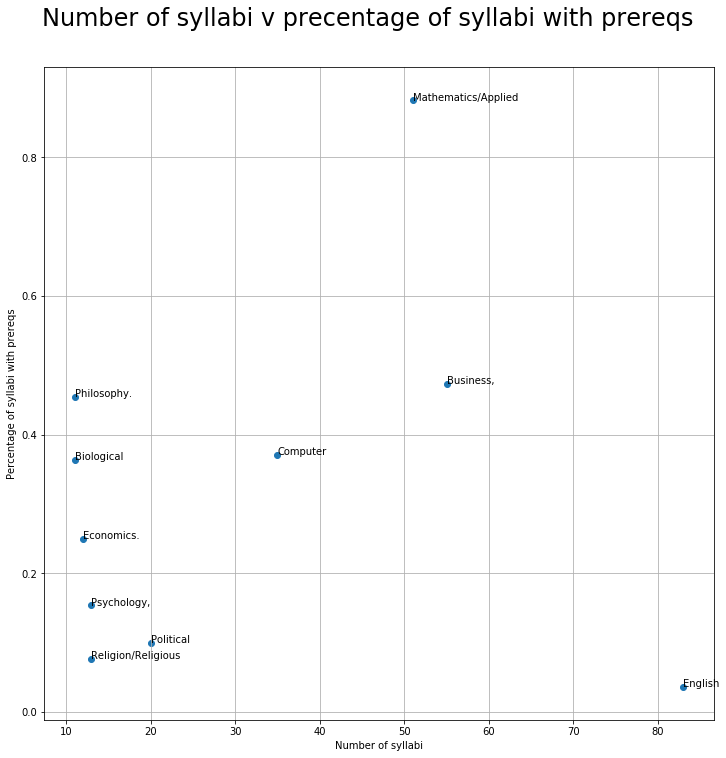

In [6]:
# we'll plot the correlation between number of syllabi and the percentage of syllabus

_ = plt.figure(figsize=(12, 12))
_ = plt.scatter(syllabi_count, percentage_count)
_ = plt.xlabel('Number of syllabi')
_ = plt.ylabel('Percentage of syllabi with prereqs')
_ = plt.suptitle("Number of syllabi v precentage of syllabi with prereqs", fontsize=24, y=.95)
_ = plt.grid()

for i, text in enumerate(domains):
    _ = plt.annotate(text, (syllabi_count[i], percentage_count[i]))

In [7]:
# There doesn't appear to be a correlation 
# It's funny how English is a major outlier, with more than 80 syllabi but less than 0.1% of all syllabi containing any prereqs

# Understanding prerequisites are important because they link the courses in a curriculum together
# They also make sure that students may only enter courses with the proper training
# We have a high-level understanding of the distribution of syllabi over departments
# Further analysis (ex. network analysis by linking syllabi nodes using prerequisite edges) may reveal even deeper trends across departments

In [8]:
# Finally, another useful metric to define would be percentage of courses with TAs
# First, let's use a similar query from above to get the total number of courses with TAs
cur.execute("SELECT A.field_name, num_ta, total_syllabi, CAST(num_ta AS decimal) / total_syllabi AS percentage FROM (SELECT field_name, COUNT(*) AS total_syllabi FROM syllabus GROUP BY field_name) A LEFT JOIN (SELECT field_name, COUNT(*) AS num_ta FROM syllabus WHERE content LIKE '%TA%' OR content LIKE '%T.A.%' GROUP BY field_name) B ON A.field_name = B.field_name")
ta_count = []
percentage_count = []
domains = []

for row in cur:
    domains.append(row[0].split(' ')[0])
    ta_count.append(row[2])
    
    if row[3] is not None:
        percentage_count.append(row[3])
    else:
        percentage_count.append(0.0) # None indicates no match was found in the LEFT JOIN

In [9]:
# I find this very hard to believe; this would mean that less than 50% of all syllabi for all departments other than Fine and Studio Arts contain any references to TAs
# However, this doesn't take into account the avergae total number of TAs per course per department
# I'd like to do that instead: maybe there's one course with some 
# Obviously, I've made the assumption that syllabi lists TAs as "TA" and not "teaching assistants" or "T.A." ("TA" from my experience seems to be the most standard way)

cur.execute("SELECT DISTINCT(field_name) FROM syllabus")
ta_per_dpmt = {row[0]: 0 for row in cur}

cur.execute("SELECT field_name, content FROM syllabus")
for row in cur:
    ta_count = re.findall(r'TA', row[1])
    ta_per_dpmt[row[0]] += len(ta_count)
    
print(ta_per_dpmt)

{'History.': 3, 'Biological and Biomedical Sciences, General/Other.': 11, 'Computer and Information Sciences.': 17, 'Political Science, Government, International Relations and National Security Studies.': 1, 'Psychology, General/Other.': 3, 'Mathematics/Applied Mathematics': 194, 'English Language and Literature/Letters': 36, 'Physics.': 0, 'Fine and Studio Arts.': 15, 'Religion/Religious Studies.': 11, 'Business, Management, and Related Support Services.': 27, 'Economics.': 26, 'Linguistics.': 1, 'Philosophy.': 4}


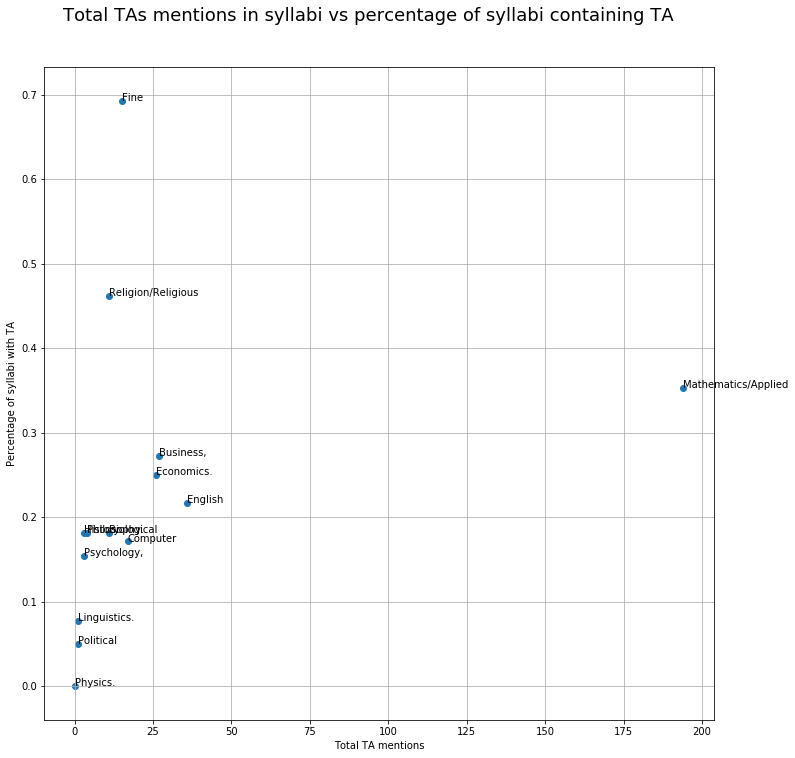

In [10]:
# as expected, the percentage of syllabi with "TA" doesn't tell the whole story
# let's visualize a scatterplot

ta_mentions = [ta_per_dpmt[dpmt] for dpmt in ta_per_dpmt]

_ = plt.figure(figsize=(12, 12))
_ = plt.scatter(ta_mentions, percentage_count)
_ = plt.xlabel('Total TA mentions')
_ = plt.ylabel('Percentage of syllabi with TA')
_ = plt.suptitle("Total TAs mentions in syllabi vs percentage of syllabi containing TA", fontsize=18, y=.95)
_ = plt.grid()

for i, text in enumerate(domains):
    _ = plt.annotate(text, (ta_mentions[i], percentage_count[i]))

In [11]:
# The independence between number of TA mentions and percentage of TAs mentions seems a little odd
# Perhaps we can infer that it could be the case that some courses just have a lot of TAs, whereas for others it's not as necessary

# TAs are super helpful to have in a course from personal and shared experience
# Helpful TAs contribute greatly to the learning environment in the classroom
# It would be useful to include a TA metric to determine degree of a liberal arts education given their importance in the classroom

In [12]:
conn.close()